<a href="https://colab.research.google.com/github/ain3ko/AppleAnalysis/blob/main/Apple%20Analys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
!pip install pyspark

In [134]:
import pyspark as dia
import numpy as kamu
import pandas as aku

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [135]:
import kagglehub
from pyspark.sql import SparkSession

path = kagglehub.dataset_download("nelgiriyewithana/apple-quality")
print("Path to dataset files:", path)

spark = SparkSession.builder \
    .appName("Apple Quality Analysis") \
    .getOrCreate()

file_path = f"{path}/apple_quality.csv"
apple = spark.read.csv(file_path, header=True, inferSchema=True)

apple.show(10)

Path to dataset files: /root/.cache/kagglehub/datasets/nelgiriyewithana/apple-quality/versions/1
+----+------------+------------+------------+------------+-----------+------------+------------+-------+
|A_id|        Size|      Weight|   Sweetness| Crunchiness|  Juiciness|    Ripeness|     Acidity|Quality|
+----+------------+------------+------------+------------+-----------+------------+------------+-------+
|   0|-3.970048523|-2.512336381| 5.346329613|-1.012008712|1.844900361| 0.329839797|-0.491590483|   good|
|   1|-1.195217191|-2.839256528| 3.664058758| 1.588232309|0.853285795| 0.867530082|-0.722809367|   good|
|   2|-0.292023862|-1.351281995|-1.738429162|-0.342615928|2.838635512|-0.038033328| 2.621636473|    bad|
|   3|-0.657195773|-2.271626609| 1.324873847|-0.097874716|3.637970491|-3.413761338| 0.790723217|   good|
|   4|  1.36421682|-1.296611877|-0.384658206| -0.55300577|3.030874354|-1.303849429| 0.501984036|   good|
|   5|-3.425399755|-1.409082204|-1.913511195|-0.555774864|-3.85

In [136]:
apple.printSchema()

root
 |-- A_id: integer (nullable = true)
 |-- Size: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- Sweetness: double (nullable = true)
 |-- Crunchiness: double (nullable = true)
 |-- Juiciness: double (nullable = true)
 |-- Ripeness: double (nullable = true)
 |-- Acidity: string (nullable = true)
 |-- Quality: string (nullable = true)



In [137]:
from pyspark.sql.functions import col

apple = apple.withColumnRenamed("A_id", "id")
apple = apple.withColumnRenamed("Size", "Ukuran")
apple = apple.withColumnRenamed("Weight", "Bobot")
apple = apple.withColumnRenamed("Sweetness", "Kemanisan")
apple = apple.withColumnRenamed("Crunchiness", "Kerenyahan")
apple = apple.withColumnRenamed("Juiciness", "Juicy")
apple = apple.withColumnRenamed("RIpeness", "Kematangan")
apple = apple.withColumnRenamed("Acidity", "Keasaman")

apple.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Ukuran: double (nullable = true)
 |-- Bobot: double (nullable = true)
 |-- Kemanisan: double (nullable = true)
 |-- Kerenyahan: double (nullable = true)
 |-- Juicy: double (nullable = true)
 |-- Kematangan: double (nullable = true)
 |-- Keasaman: string (nullable = true)
 |-- Quality: string (nullable = true)



In [138]:
apple.describe().show()

+-------+------------------+-------------------+-------------------+--------------------+------------------+------------------+------------------+--------------------+-------+
|summary|                id|             Ukuran|              Bobot|           Kemanisan|        Kerenyahan|             Juicy|        Kematangan|            Keasaman|Quality|
+-------+------------------+-------------------+-------------------+--------------------+------------------+------------------+------------------+--------------------+-------+
|  count|              4000|               4000|               4000|                4000|              4000|              4000|              4000|                4001|   4000|
|   mean|            1999.5|-0.5030146298267509|-0.9895465445945022|-0.47047851978824984| 0.985477903858501|0.5121179684932494|0.4982774280305005| 0.07687729571600004|   NULL|
| stddev|1154.8448669265786|   1.92805868885498| 1.6025072141517547|  1.9434406589204516|1.4027572042119638|1.9302856730

In [139]:
from pyspark.sql.functions import col, sum, when

missing_values = apple.select(
    *[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in apple.columns]
)

print("Missing values per column:")
missing_values.show()

Missing values per column:
+---+------+-----+---------+----------+-----+----------+--------+-------+
| id|Ukuran|Bobot|Kemanisan|Kerenyahan|Juicy|Kematangan|Keasaman|Quality|
+---+------+-----+---------+----------+-----+----------+--------+-------+
|  1|     1|    1|        1|         1|    1|         1|       0|      1|
+---+------+-----+---------+----------+-----+----------+--------+-------+



In [140]:
from pyspark.sql.functions import mean, when, isnull

for col_name in ['id', 'Ukuran', 'Bobot', 'Kemanisan', 'Kerenyahan', 'Juicy', 'Kematangan', 'Keasaman', 'Quality']:
    mean_value = apple.select(mean(when(~isnull(col(col_name)), col(col_name)))).collect()[0][0]

    apple = apple.fillna({col_name: mean_value if mean_value is not None else 0})

In [141]:
from pyspark.sql.functions import col, sum, when

missing_values = apple.select(
    *[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in apple.columns]
)

print("Missing values per column:")
missing_values.show()

Missing values per column:
+---+------+-----+---------+----------+-----+----------+--------+-------+
| id|Ukuran|Bobot|Kemanisan|Kerenyahan|Juicy|Kematangan|Keasaman|Quality|
+---+------+-----+---------+----------+-----+----------+--------+-------+
|  0|     0|    0|        0|         0|    0|         0|       0|      0|
+---+------+-----+---------+----------+-----+----------+--------+-------+



In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

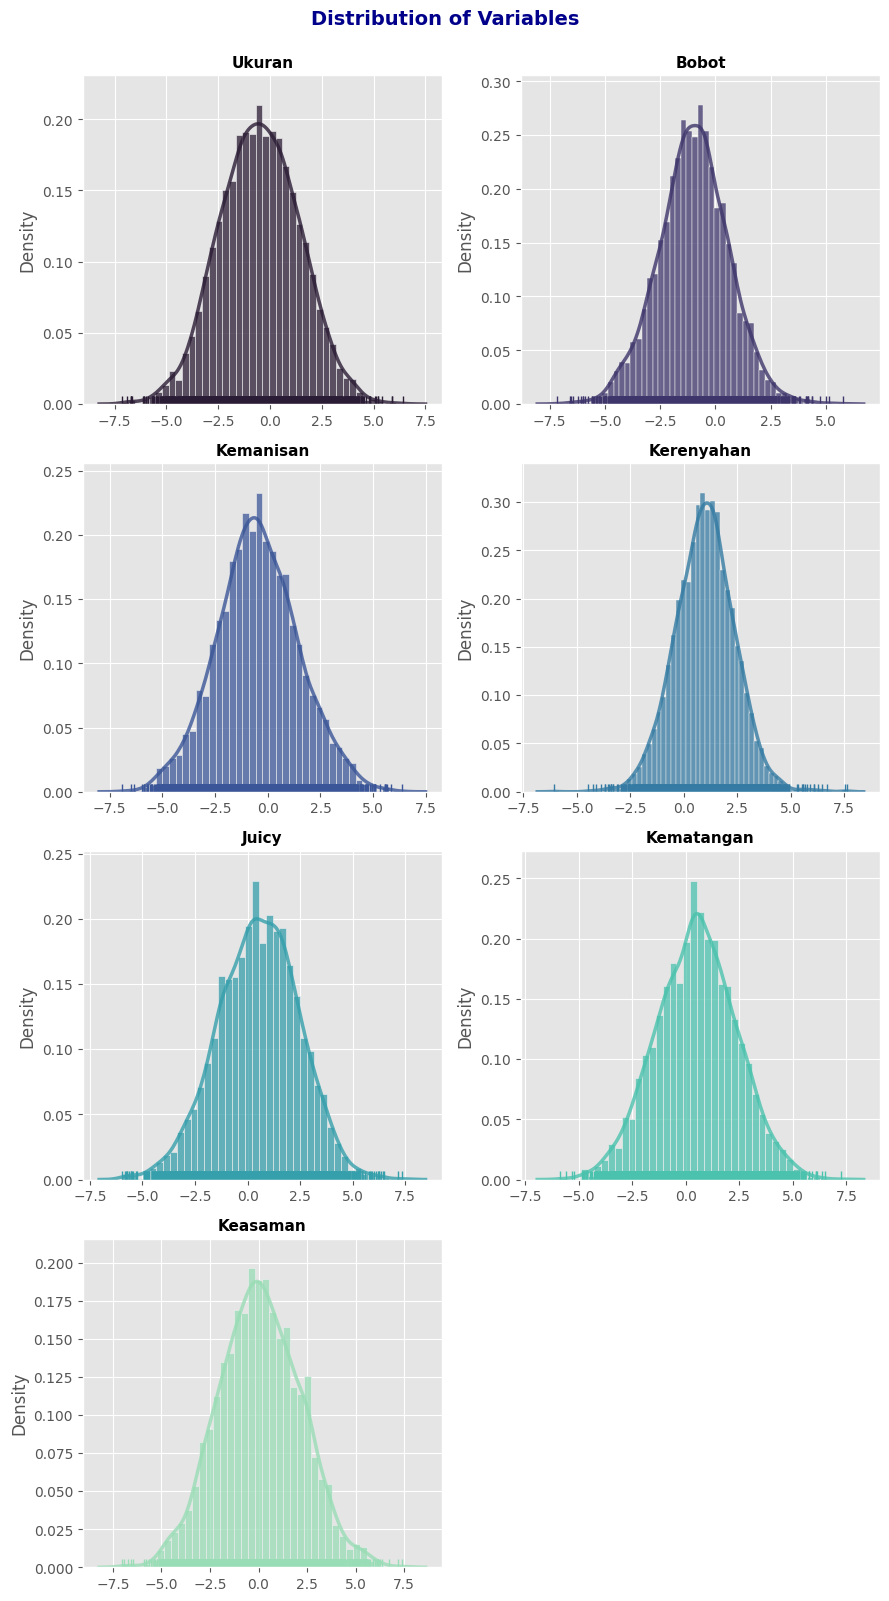

In [159]:
data = apple.toPandas()

cols = data.columns[:-1]
numeric_cols = [col for col in cols if col not in ['id', 'Quality']]

for col in numeric_cols:
    data[col] = aku.to_numeric(data[col], errors='coerce')

data = data.dropna(subset=numeric_cols)

colors = sns.color_palette('mako', len(numeric_cols))

num_cols = len(numeric_cols)
num_rows = (num_cols + 1) // 2
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(9, num_rows * 4))
plt.style.use("ggplot")
axs = axs.flat

#visualisasi untuk setiap kolom numerik
for i, col in enumerate(numeric_cols):
    sns.kdeplot(data, x=col, alpha=0.8, linewidth=2.5, color=colors[i], ax=axs[i])
    sns.histplot(data, x=col, stat='density', color=colors[i], ax=axs[i])
    sns.rugplot(data, x=col, color=colors[i], ax=axs[i])
    axs[i].set_xlabel("")
    axs[i].set_title(col, fontsize=11, fontweight="bold", color="black")

fig.suptitle("Distribution of Variables", fontsize=14, fontweight="bold", color="darkblue", y=0.998)

if num_cols < len(axs):
    for j in range(num_cols, len(axs)):
        fig.delaxes(ax=axs[j])

fig.tight_layout()
plt.show()

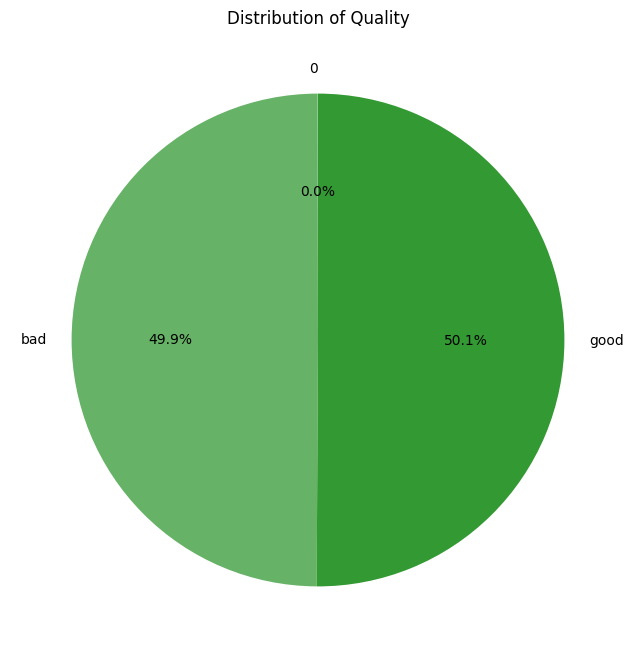

In [142]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt

quality_distribution = apple.groupBy("Quality").agg(count("*").alias("count"))

quality_distribution_pd = quality_distribution.toPandas()

colors = ['#b2d8b2', '#66b266', '#339933', '#006600', '#004d00']

plt.figure(figsize=(8, 8))
plt.pie(
    quality_distribution_pd["count"],
    labels=quality_distribution_pd["Quality"],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors
)
plt.title("Distribution of Quality")
plt.show()

In [149]:
apple = apple.withColumn(
    "Quality",
    when(col("Quality") == "0", None).otherwise(col("Quality"))
)

In [150]:
apple = apple.filter(apple["Quality"].isNotNull())

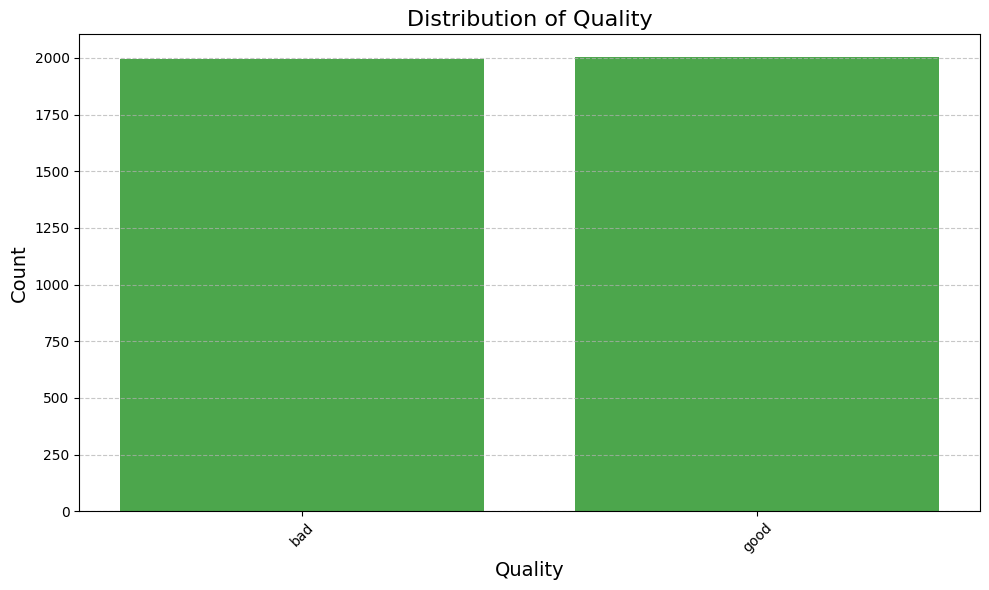

In [151]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt

quality_distribution = apple.groupBy("Quality").agg(count("*").alias("count"))
quality_distribution_pd = quality_distribution.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(
    quality_distribution_pd["Quality"],
    quality_distribution_pd["count"],
    color='green',
    alpha=0.7
)
plt.title("Distribution of Quality", fontsize=16)
plt.xlabel("Quality", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [143]:
from pyspark.sql.functions import col

numeric_columns = ['Ukuran', 'Bobot', 'Kemanisan', 'Kerenyahan', 'Juicy', 'Kematangan', 'Keasaman', 'Quality']
apple_numeric = apple.select([col(c) for c in numeric_columns])

apple_pd = apple_numeric.toPandas()

apple_pd = apple_pd.apply(aku.to_numeric, errors='coerce')
apple_pd = apple_pd.dropna(axis=1)

correlation_matrix = apple_pd.corr()

# Cetak correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
              Ukuran     Bobot  Kemanisan  Kerenyahan     Juicy  Kematangan
Ukuran      1.000000 -0.170702  -0.324680    0.169868 -0.018892   -0.134773
Bobot      -0.170702  1.000000  -0.154246   -0.095882 -0.092263   -0.243824
Kemanisan  -0.324680 -0.154246   1.000000   -0.037552  0.095882   -0.273800
Kerenyahan  0.169868 -0.095882  -0.037552    1.000000 -0.259607   -0.201982
Juicy      -0.018892 -0.092263   0.095882   -0.259607  1.000000   -0.097144
Kematangan -0.134773 -0.243824  -0.273800   -0.201982 -0.097144    1.000000


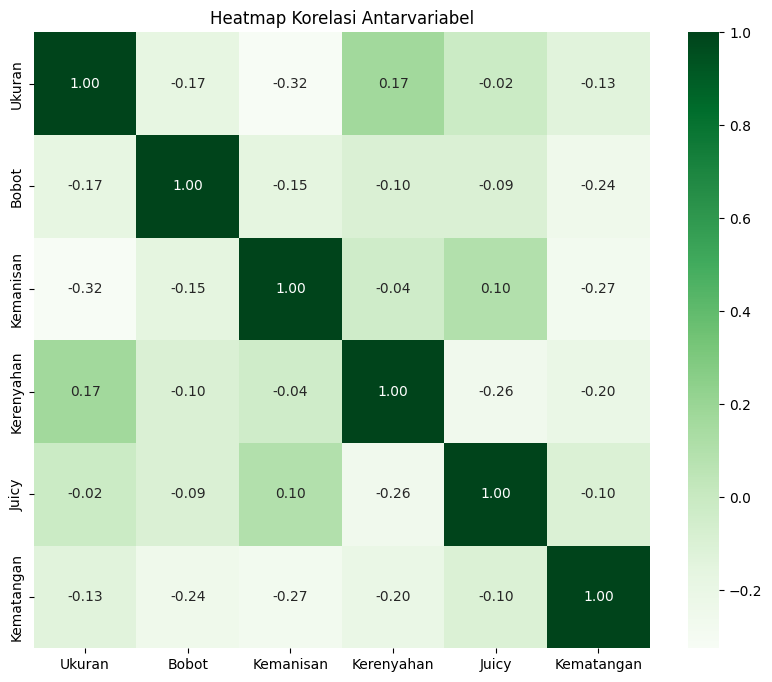

In [144]:
#Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="Greens",
    fmt=".2f",
    square=True,
    cbar=True
)
plt.title("Heatmap Korelasi Antarvariabel")
plt.show()